# Trees

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb
import pickle
import math

plt.style.use('ggplot')

In [2]:
def rmsle(model, X, y):
    '''
    Calculates rmsle as set by Kaggle
    '''
    return (math.sqrt(np.mean((np.log(np.exp(model.predict(X))) - np.log(np.exp(y))) ** 2)))

Here we use decision trees to build models of the sales price

In [3]:
# Load the train set
df = pd.read_csv('./data/new_train.csv')
df.drop(['Unnamed: 0', 'Id'], axis=1, inplace=True)

# Load categorical variables
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))

df.shape

(1460, 279)

## Descision Tree Regressor

In [4]:
data = df.copy()

# Create sets
X = data.copy().drop('SalePrice', axis=1)
y = np.log(data.copy()['SalePrice'])


We perform cross-validation to find optimal pruning parameters.

In [5]:
# Create placeholders for the results
min_split = []
scores = []
min_leaf = []

# Set optimization parameters
m_smpl = np.linspace(start=10, stop=100,num=91, dtype='int')
m_lf = np.linspace(2, 7, num=6, dtype='int')

# Run optimization
for smpl in m_smpl:
    for lf in m_lf:
        tree = RandomForestRegressor(min_samples_split=smpl, min_samples_leaf=lf, random_state=0)
        cv = cross_val_score(tree,X, y, cv = 10)
        score = np.mean(cv)
        min_split = min_split + [smpl]
        min_leaf = min_leaf + [lf]
        scores = scores + [score]


In [6]:
tmp_ = pd.DataFrame({'score':scores, 'smpl':min_split, 'leaf':min_leaf})

In [7]:
tmp_ = tmp_.sort_values('score', ascending=False).head(20)
tmp_

,score,smpl,leaf
0,0.864988,10,2
6,0.864943,11,2
12,0.864438,12,2
18,0.863936,13,2
7,0.863387,11,3
1,0.862765,10,3
24,0.862740,14,2
13,0.862572,12,3
19,0.862506,13,3
30,0.862120,15,2


We use optimized parameters (min_amples_split=31 and min_samples_leaf=5) to build the final model.

In [8]:
# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 278)
X_test : (438, 278)
y_train : (1022,)
y_test : (438,)


We perform train test validation

In [9]:
smpl = tmp_.iloc[0,1]
lf = tmp_.iloc[0,2]
regression_tree  = RandomForestRegressor(min_samples_split=smpl, min_samples_leaf=lf,
  random_state=0)

Model train accuracy (rmsle):  0.08722736213141796
Model test accuracy (rmsle):  0.13897378525896256


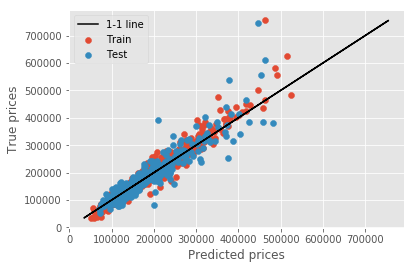

In [10]:
model_tmp = regression_tree.fit(X_train,y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test, y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()


Fit to the whole dataset

In [11]:
tree = RandomForestRegressor(min_samples_leaf=1,
  random_state=0)

tree = tree.fit(X,y)

score_tree = rmsle(tree, X, y)

print('Model accuracy rmse: ', score_tree)

Model accuracy rmse:  0.06376142797180404


In [12]:
importance = pd.DataFrame({'features':X.columns, 'imp':regression_tree.feature_importances_}).\
                        sort_values('imp',ascending=False)

importance_top20 = importance.iloc[:20,]

<BarContainer object of 20 artists>

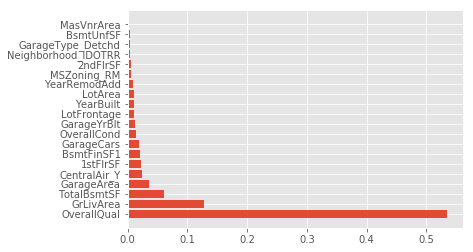

In [13]:
plt.barh(importance_top20.features, importance_top20.imp)

List factors with positive importance

In [14]:
feature_list_dt = list(importance.loc[importance.imp>0,'features'])

In [15]:
# Save features
pickle.dump(obj=feature_list_dt, file=open('./tmp/feaure_list_dt.list','wb'))

## Gradient Boosting

We are using boosted tree to model the prices.

In [16]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

alphas = np.linspace(1, 20, 3)

params = {"max_depth":3, "eta":0.1, "subsample":0.7}
cv_xgb = xgb.cv(params, dtrain,  num_boost_round=1000, early_stopping_rounds=100, verbose_eval=False)


[15:43:28] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[15:43:29] /workspace/sr

[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /work

[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /work

[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /work

[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[15:43:29] /works

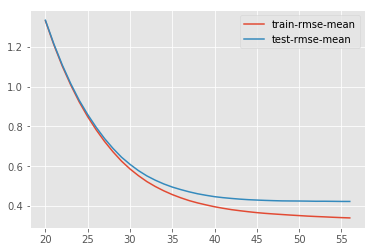

In [17]:
# Plot cv results
cv_xgb.iloc[20:, [0,2]].plot()

Fit to new test and train sets

Model train accuracy (rmsle):  0.11541178627112067
Model test accuracy (rmsle):  0.16317197857171314


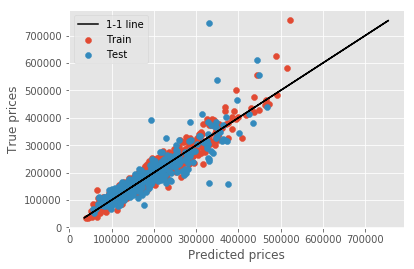

In [18]:
# Fit a model 
model_tmp = xgb.XGBRegressor(n_estimators=30, max_depth=2, learning_rate=0.6, subsample=0.7) #the params were tuned using xgb.cv
model_tmp = model_tmp.fit(X_train, y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test, y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()


Fit to the whole dataset

In [19]:
xgb_mod = xgb.XGBRegressor(n_estimators=30, max_depth=2, learning_rate=0.6, subsample=0.7) #the params were tuned using xgb.cv
xgb_mod = xgb_mod.fit(X, y)

score_xgb = rmsle(xgb_mod, X, y)

print('Model accuracy rmse: ', score_xgb)


Model accuracy rmse:  0.11811972843556778


## Combine the models

We combine the models and pickle them for use on the train set

In [20]:
# Models

models = ['tree', 'xgb_mod']
scores = [score_tree, score_xgb]

models_comb = pd.DataFrame({'model':models, 'score': scores})
print(models_comb)

# Pickle
pickle.dump(models_comb, open('./tmp/tree_comb', 'wb'))

     model     score
0     tree  0.063761
1  xgb_mod  0.118120


Pickle models

In [21]:
models_obj = [tree, xgb_mod]

for i, model in enumerate(models_obj):
    name = './tmp/'+models[i]+'.model'
    pickle.dump(model, open(name, 'wb'))
